In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-startups-train-27042024/kaggle_startups_train_27042024.csv
/kaggle/input/kaggle-startups-test-27042024-csv/kaggle_startups_test_27042024.csv
/kaggle/input/kaggle-startups-sample-submit-27042024/kaggle_startups_sample_submit_27042024.csv


In [201]:
!pip install phik
!pip install optuna-integration
!pip install shap 
!pip install yellowbrick
!pip install scikit-learn
!pip install imbalanced-learn
!pip install category_encoders

In [202]:
import matplotlib.pyplot as plt
import sklearn
import math
import time
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import phik
import shap
import imblearn
import plotly.io as pio

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.metrics import make_scorer, RocCurveDisplay, roc_auc_score, f1_score, mean_absolute_error, r2_score, mean_squared_error,mean_absolute_error, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from math import factorial, sqrt
from optuna.integration import OptunaSearchCV
from sklearn.preprocessing import PolynomialFeatures

from category_encoders.binary import BinaryEncoder
from category_encoders.helmert import HelmertEncoder

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from phik import phik_matrix
from phik.report import plot_correlation_matrix


## Откроем файлы:

In [203]:
train_df = pd.read_csv('/kaggle/input/kaggle-startups-train-27042024/kaggle_startups_train_27042024.csv', sep=',')
test_df = pd.read_csv('/kaggle/input/kaggle-startups-test-27042024-csv/kaggle_startups_test_27042024.csv', sep=',')
sample_df = pd.read_csv('/kaggle/input/kaggle-startups-sample-submit-27042024/kaggle_startups_sample_submit_27042024.csv', sep=',')

In [204]:
train_df.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-01-20,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [205]:
test_df.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-01,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2007-01-01,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2002-07-22,2003-06-02,2003-06-02,5642
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2013-01-01,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2012-05-15,2013-08-09,2013-08-09,2057


In [206]:
sample_df.head(10)

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,closed
5,Quickfire Games,closed
6,Sente Inc.,operating
7,Triosyn,operating
8,Urgent.ly,operating
9,Map Decisions,closed


### Проверим типы данных:

In [207]:
list_df = [train_df, test_df, sample_df]
list_name_df = ['train_df', 'test_df', 'sample_df']
for df, name_df in zip(list_df, list_name_df):
    print(f'Датафрейм {name_df} ', '\n', '-'*45)
    print(f'{df.info()} ', '\n')

Датафрейм train_df  
 ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None  

Датафрейм test_df  
 -----------

**Вывод:**

 - есть столбцы  в неверном формате, переведем их в формат даты.

In [208]:
list_date = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
list_date_t = ['founded_at', 'first_funding_at', 'last_funding_at']
for date, date_t in zip(list_date, list_date_t):
    train_df[date] = pd.to_datetime(train_df[date], format = '%Y-%m-%d')
    test_df[date_t] = pd.to_datetime(test_df[date_t], format = '%Y-%m-%d')

In [209]:
display(train_df.info())
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(8)
memory 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


### Проверим файлы на пропуски:

In [210]:
def nan(df):
    for i in df.columns:
        print(f'Кол-во пропусков в столбце {i}: {df[i].isna().sum()}')
        #ед., {(df[i].isna().sum() / len(df["name"])*100).round(0)}%

In [211]:
nan(train_df)

Кол-во пропусков в столбце name: 1
Кол-во пропусков в столбце category_list: 2465
Кол-во пропусков в столбце funding_total_usd: 10069
Кол-во пропусков в столбце status: 0
Кол-во пропусков в столбце country_code: 5501
Кол-во пропусков в столбце state_code: 6762
Кол-во пропусков в столбце region: 6358
Кол-во пропусков в столбце city: 6358
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце closed_at: 47599


In [212]:
nan(test_df)

Кол-во пропусков в столбце name: 0
Кол-во пропусков в столбце category_list: 591
Кол-во пропусков в столбце funding_total_usd: 2578
Кол-во пропусков в столбце country_code: 1382
Кол-во пропусков в столбце state_code: 1695
Кол-во пропусков в столбце region: 1589
Кол-во пропусков в столбце city: 1587
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце lifetime: 0


In [213]:
nan(sample_df)

Кол-во пропусков в столбце name: 0
Кол-во пропусков в столбце status: 0


**Вывод:**

 - много пропусов в данных.

#### Столбец category_list, country_code, state_code, region, city: заполним пропущенные значения на unknown:

In [214]:
list_fill = ['category_list', 'country_code', 'state_code', 'region', 'city']

for col in list_fill:
    train_df[col] = train_df[col].fillna(value='unknown')
    test_df[col] = test_df[col].fillna(value='unknown')

In [215]:
display(nan(train_df))
nan(test_df)

Кол-во пропусков в столбце name: 1
Кол-во пропусков в столбце category_list: 0
Кол-во пропусков в столбце funding_total_usd: 10069
Кол-во пропусков в столбце status: 0
Кол-во пропусков в столбце country_code: 0
Кол-во пропусков в столбце state_code: 0
Кол-во пропусков в столбце region: 0
Кол-во пропусков в столбце city: 0
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце closed_at: 47599


None

Кол-во пропусков в столбце name: 0
Кол-во пропусков в столбце category_list: 0
Кол-во пропусков в столбце funding_total_usd: 2578
Кол-во пропусков в столбце country_code: 0
Кол-во пропусков в столбце state_code: 0
Кол-во пропусков в столбце region: 0
Кол-во пропусков в столбце city: 0
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце lifetime: 0


#### Столбец funding_total_usd:

In [216]:
def box_hist(df, column, hue):
    fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [0.5, 3]})
    sns.boxplot(x=df[column], ax=axs[0], palette="pastel")
    sns.histplot(data=df, x=column, hue=hue, ax=axs[1], bins=30, multiple="stack", palette=["#F08080", "#3CB371"])
    axs[0].set_xlabel(None)
    axs[0].set_title('Гистограмма и Boxplot')
    plt.show()
    print(df[column].describe())

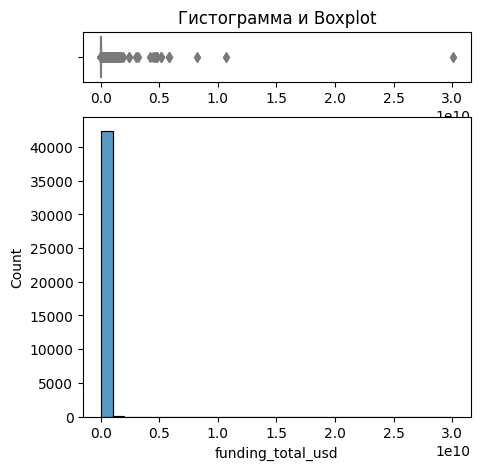

count    4.244500e+04
mean     1.824826e+07
std      1.871217e+08
min      1.000000e+00
25%      3.360000e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64


In [217]:
box_hist(train_df,'funding_total_usd', None)

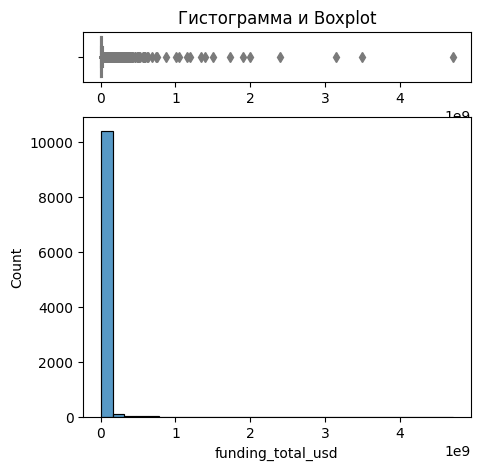

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64


In [218]:
box_hist(test_df,'funding_total_usd', None)

**Вывод:**
    
  - есть выбросы , поэтому заполним пропуски медианным значением

In [219]:
train_df['funding_total_usd'] = train_df['funding_total_usd'].fillna(train_df['funding_total_usd'].median())
test_df['funding_total_usd'] = test_df['funding_total_usd'].fillna(test_df['funding_total_usd'].median())

In [220]:
display(nan(train_df))
nan(test_df)

Кол-во пропусков в столбце name: 1
Кол-во пропусков в столбце category_list: 0
Кол-во пропусков в столбце funding_total_usd: 0
Кол-во пропусков в столбце status: 0
Кол-во пропусков в столбце country_code: 0
Кол-во пропусков в столбце state_code: 0
Кол-во пропусков в столбце region: 0
Кол-во пропусков в столбце city: 0
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце closed_at: 47599


None

Кол-во пропусков в столбце name: 0
Кол-во пропусков в столбце category_list: 0
Кол-во пропусков в столбце funding_total_usd: 0
Кол-во пропусков в столбце country_code: 0
Кол-во пропусков в столбце state_code: 0
Кол-во пропусков в столбце region: 0
Кол-во пропусков в столбце city: 0
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце lifetime: 0


#### Заполним пропуски в столбце closed_at файла train_df:

In [221]:
train_df.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'], format = '%Y-%m-%d')

#### Добавим столбец lifetime в файл train_df:

In [222]:
train_df['lifetime'] = (train_df.closed_at - train_df.founded_at).dt.days
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      52514 non-null  object        
 2   funding_total_usd  52514 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       52514 non-null  object        
 5   state_code         52514 non-null  object        
 6   region             52514 non-null  object        
 7   city               52514 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          52514 non-null  datetime64[ns]
 13  lifetime           52514 non-null  int64         
dtypes: dat

In [223]:
display(nan(train_df))

Кол-во пропусков в столбце name: 1
Кол-во пропусков в столбце category_list: 0
Кол-во пропусков в столбце funding_total_usd: 0
Кол-во пропусков в столбце status: 0
Кол-во пропусков в столбце country_code: 0
Кол-во пропусков в столбце state_code: 0
Кол-во пропусков в столбце region: 0
Кол-во пропусков в столбце city: 0
Кол-во пропусков в столбце funding_rounds: 0
Кол-во пропусков в столбце founded_at: 0
Кол-во пропусков в столбце first_funding_at: 0
Кол-во пропусков в столбце last_funding_at: 0
Кол-во пропусков в столбце closed_at: 0
Кол-во пропусков в столбце lifetime: 0


None

**Вывод:**
    
   - пропуски заполнены (столбец name не понадобится)

#### Проверим явные дубликаты в каждом датафрейме.

In [224]:
df = [train_df, test_df]
df_name = ['train_df', 'test_df']

for d, n in zip(df, df_name):
    print(f'В датафрейме "{n}" кол-во дубликатов: {d.duplicated().sum()}')

В датафрейме "train_df" кол-во дубликатов: 0
В датафрейме "test_df" кол-во дубликатов: 0


**Вывод:**
    
   - явных дубликатов нет.

#### Проверим уникальные значения в каждом датафрейме.

In [225]:
train_df.nunique()

name                 52513
category_list        22109
funding_total_usd    15551
status                   2
country_code           135
state_code             301
region                1037
city                  4478
funding_rounds          19
founded_at            5401
first_funding_at      4603
last_funding_at       4305
closed_at             3008
lifetime              5761
dtype: int64

In [226]:
test_df.nunique()

name                 13125
category_list         6207
funding_total_usd     4549
country_code            97
state_code             236
region                 689
city                  2118
funding_rounds          15
founded_at            3165
first_funding_at      3299
last_funding_at       3021
lifetime              3421
dtype: int64

In [227]:
sample_df.nunique()

name      13125
status        2
dtype: int64

#### Выделим в столбце category_list основную категорию:

In [228]:
train_df['category_list'].head(10)

0                      Online Reservations|Restaurants
1                Manufacturing|Medical|Medical Devices
2                                        Biotechnology
3                                          Health Care
4                                        Manufacturing
5                                               Mobile
6    Analytics|Business Analytics|Social CRM|Social...
7                                             Software
8                                        Biotechnology
9                                       Semiconductors
Name: category_list, dtype: object

In [229]:
def main_category(df, columns):
    
    for column in columns:
        df[f'main_{column}'] = df[column].str.split('|').str[0]

In [230]:
train_df['main_category'] = train_df['category_list'].str.split('|').str[0]
test_df['main_category'] = test_df['category_list'].str.split('|').str[0]

In [231]:
display(train_df[['category_list', 'main_category']].head())
test_df[['category_list', 'main_category']].head()

,category_list,main_category
0,Online Reservations|Restaurants,Online Reservations
1,Manufacturing|Medical|Medical Devices,Manufacturing
2,Biotechnology,Biotechnology
3,Health Care,Health Care
4,Manufacturing,Manufacturing


,category_list,main_category
0,Clean Technology,Clean Technology
1,Hospitality,Hospitality
2,Finance,Finance
3,Software|Video|Video Streaming,Software
4,Software,Software


In [232]:
display(train_df[['category_list', 'main_category']].nunique())
test_df[['category_list', 'main_category']].nunique()

category_list    22109
main_category      708
dtype: int64

category_list    6207
main_category     560
dtype: int64

**Вывод:**

- количество категорий значительно уменьшилось.



In [233]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,main_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923,Online Reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,Health Care
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650,Manufacturing


In [234]:
test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,main_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,unknown,unknown,1,2008-06-01,2009-07-01,2009-07-01,3501,Clean Technology
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717,Hospitality
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295,Finance
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748,Software
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209,Software


#### Проведем корреляционный анализ всех признаков с помощью коэффициента корреляции Фи

In [235]:
#phik_overview = train_df.sample(3000).phik_matrix(interval_cols = ['funding_total_usd', 'funding_rounds', 'lifetime'])
#plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
#                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
#                        figsize=(10,10))
#plt.tight_layout()

**Вывод:**

- фичи founded_at, first_funding_at, last_funding_at полностью мультиколлениарны, включать в модель их не будем.
- country_code, state_code, region city - мультиколлениарны, оставляем только country_code.
- founded_at, first_funding_at, last_funding_at также мультиколлениарны, в модель их не включаем.
- также не включаем name.
- funding_total_usd не имеет корреляции с целевым признаком status, в модель не включаем.
- main_category и category_list	 имеют одинаковую корреляцию с целевым признаком, но т.к. main_category содержит меньше уникальных значений, то в модели будем использовать его.
- таким образом, список фичей для модели:

1. country_code 
2. funding_rounds
3. lifetime
4. main_category



#### Проверим сбалансированность данных в тренировочном датафрейме:

In [236]:
def visualization_cat(df, column, x_label_bar, y_label_bar, title_bar, title_pie):
    """""
    Визуализация категориальных данных
    
    """""

    group_pie = (df.groupby(column).agg({column: ['count']}))
    group_pie['%'] = (group_pie[column]['count'] / df[column].count() *100).round(0)
    colors = ['#3CB371',"#FF0000"]
    group_pie = group_pie.sort_values(by='%', ascending=False)
    (group_pie
     .plot(kind = 'pie',
           y='%',
           labeldistance=1.15,
           ylabel= '',
           legend=False,
           title=title_pie,
           figsize = (10,5),
           autopct='%1.0f%%',
           #fontsize=11,
           colors=colors,
           wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },
          )
    )
    plt.show()

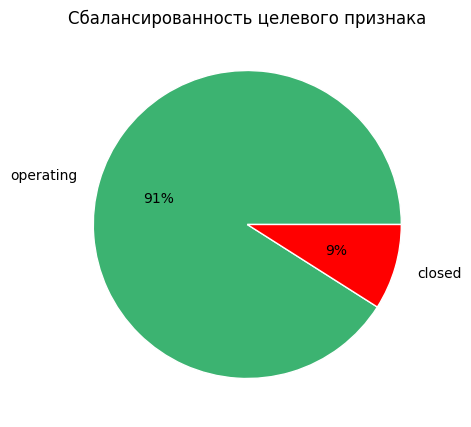

In [237]:
visualization_cat(train_df, 'status', 
                  'status', 'status' , 
                  'status', 'Сбалансированность целевого признака')

**Вывод:**
    
- данные не сбалансированы, при низкой метрике F1 можно будет попробовать устранить дисбаланс.

## Подготовка данных

### Отберем признаки:

In [238]:
train = train_df.drop(['name',
                       'category_list',
                       'funding_total_usd',
                       'state_code',
                       'region',
                       'city',
                       'founded_at',
                       'first_funding_at',
                       'closed_at',
                       'last_funding_at'], axis=1)
test = test_df.drop(['name',
                       'category_list',
                       'funding_total_usd',
                       'state_code',
                       'region',
                       'city',
                       'founded_at',
                       'first_funding_at',
                       'last_funding_at'], axis=1)

In [239]:
train.head()

,status,country_code,funding_rounds,lifetime,main_category
0,operating,CHE,2,2923,Online Reservations
1,operating,USA,4,4748,Manufacturing
2,operating,USA,3,4383,Biotechnology
3,operating,unknown,3,5114,Health Care
4,operating,USA,1,2650,Manufacturing


In [240]:
test.head()

,country_code,funding_rounds,lifetime,main_category
0,NIC,1,3501,Clean Technology
1,USA,1,2717,Hospitality
2,LUX,2,1295,Finance
3,USA,4,4748,Software
4,CAN,1,6209,Software


#### Разделим данные файла train:

In [241]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = train.drop('status', axis=1)
y = train['status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [306]:
np.unique (y_train)

array([0, 1])

#### Применим LabelEncoder() для целевого признака:

In [243]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

#### Отберем количественные и категориальные признаки

In [244]:
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
num_col_names = X_train.select_dtypes(include='number').columns.tolist()

In [245]:
display(cat_col_names)
num_col_names

['country_code', 'main_category']

['funding_rounds', 'lifetime']

## Обучение моделей

In [255]:
X_train['country_code'].nunique()

127

### Модель DecisionTreeClassifier

In [268]:
binary_columns = ['main_category','country_code' ]

num_columns = ['lifetime', 'funding_rounds']

binary_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'binary', 
            BinaryEncoder()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('binary', binary_pipe, binary_columns),
        ('num', StandardScaler(), num_columns),
    ], remainder='passthrough'
    
)

pipe_final_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_tree = [{
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()], #,'passthrough'
    'models__min_samples_split': range(1, 20),
    'models__min_samples_leaf': range(2, 20),
    'models__max_depth': [range(2, 20), None] 
    }
]

In [269]:
grid_tree = RandomizedSearchCV(pipe_final_tree,
                               param_grid_tree, 
                               cv=5, 
                               n_jobs=-1,
                               n_iter=30,
                               scoring='f1',
                               random_state=RANDOM_STATE)

In [270]:
grid_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['main_category',
                                                                                'country_code']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['lifetime',
                                                                                'funding_rounds'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'models__max_depth': [range(2, 20),
                                                               None],
                                         'models__min_samples_leaf': range(2, 20),
                                         'models__min_samples_split': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   random_state=42, scoring='f1')

In [283]:
print(f'Лучшие параметры модели:  , {grid_tree.best_params_} \n\n Метрика F1: {(grid_tree.best_score_).round(4)}')

Лучшие параметры модели:  , {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 13, 'models__min_samples_leaf': 18, 'models__max_depth': None} 

 Метрика F1: 0.9719


#### Обучим модель с лучшими параметрами

In [284]:
binary_columns = ['main_category','country_code' ]

num_columns = ['lifetime', 'funding_rounds']

binary_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'binary', 
            BinaryEncoder()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('binary', binary_pipe, binary_columns),
        ('num', MinMaxScaler(), num_columns),
    ], remainder='passthrough'
    
)

pipe_final_tree_best = Pipeline(
    [
        ('preprocessor', data_preprocessor)
    ]
)

In [285]:
X_train_procecced_tree = pipe_final_tree_best.fit_transform(X_train)
X_test_procecced_tree = pipe_final_tree_best.transform(X_test)

In [286]:
model_tree = DecisionTreeClassifier(min_samples_split = 13, 
                                  min_samples_leaf =  18, 
                                  max_depth =  None, 
                                  random_state=RANDOM_STATE)
model_tree.fit(X_train_procecced_tree, y_train)

DecisionTreeClassifier(min_samples_leaf=18, min_samples_split=13,
                       random_state=42)

In [320]:
metric_tree = (f1_score(y_test, model_tree.predict(X_test_procecced_tree))).round(4)
print(f'F1 на тестовой выборке: {metric_tree}')

F1 на тестовой выборке: 0.9727


#### Модель LogisticRegression

In [325]:
binary_columns = ['main_category','country_code' ]

num_columns = ['lifetime', 'funding_rounds']

binary_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'binary', 
            BinaryEncoder()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('binary', binary_pipe, binary_columns),
        ('num', StandardScaler(), num_columns),
    ], remainder='passthrough'
    
)

pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

param_grid_lr = [{
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()], #,'passthrough'
    'models__penalty': ['l2', 'l1', 'elasticnet'],
    'models__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky', 'sag'],
    'models__C': range(1, 30),
    'models__class_weight': ['balanced', 'None']
    }
]

In [326]:
grid_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [327]:
grid_lr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['main_category',
                                                                                'country_code']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['lifetime',
                                                                                'funding_rounds'])])),
                                             ('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'models__C': range(1, 30),
                                         'models__class_weight': ['balanced',
                                                                  'None'],
                                         'models__penalty': ['l2', 'l1',
                                                             'elasticnet'],
                                         'models__solver': ['lbfgs',
                                                            'liblinear', 'saga',
                                                            'newton-cholesky',
                                                            'sag'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   random_state=42, scoring='f1')

In [329]:
print(f'Лучшие параметры модели:  , {grid_lr.best_params_} \n\n Метрика F1: {(grid_lr.best_score_).round(4)}')

Лучшие параметры модели:  , {'preprocessor__num': MinMaxScaler(), 'models__solver': 'sag', 'models__penalty': 'l2', 'models__class_weight': 'balanced', 'models__C': 29} 

 Метрика F1: 0.8309


#### Обучим модель с лучшими параметрами

In [330]:
binary_columns = ['main_category','country_code' ]

num_columns = ['lifetime', 'funding_rounds']

binary_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'binary', 
            BinaryEncoder()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('binary', binary_pipe, binary_columns),
        ('num', StandardScaler(), num_columns),
    ], remainder='passthrough'
    
)

pipe_final_lr_best = Pipeline(
    [
        ('preprocessor', data_preprocessor),
    ]
)

In [331]:
X_train_procecced_lr = pipe_final_lr_best.fit_transform(X_train)
X_test_procecced_lr = pipe_final_lr_best.transform(X_test)

In [332]:
model_lr_best = LogisticRegression(solver='sag', 
                                          penalty ='l2' ,
                                          class_weight='balanced', 
                                          C =  29, 
                                   random_state=RANDOM_STATE)
model_lr_best.fit(X_train_procecced_lr, y_train)

LogisticRegression(C=29, class_weight='balanced', random_state=42, solver='sag')

In [342]:
metric_lr = (f1_score(y_test, model_lr_best.predict(X_test_procecced_lr))).round(4)
print(f'f1 на тестовой выборке: {metric_lr}')

f1 на тестовой выборке: 0.8297


#### Полинимизируем признаки:

In [343]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_procecced_lr)
X_test_poly = poly.transform(X_test_procecced_lr)
model_lr_best.fit(X_train_poly, y_train)

LogisticRegression(C=29, class_weight='balanced', random_state=42, solver='sag')

In [344]:
metric_lr_poly = (f1_score(y_test, model_lr_best.predict(X_test_poly))).round(4)
print(f'f1 на тестовой выборке: {metric_lr_poly}')

f1 на тестовой выборке: 0.8796


### Модель SVC

In [345]:
binary_columns = ['main_category','country_code' ]

num_columns = ['lifetime', 'funding_rounds']

binary_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'binary', 
            BinaryEncoder()
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('binary', binary_pipe, binary_columns),
        ('num', StandardScaler(), num_columns),
    ], remainder='passthrough'
    
)

pipe_final_SVC = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVC(random_state=RANDOM_STATE, probability=True))
    ]
)

param_grid_SVC = [{
    'preprocessor__num': [StandardScaler(), RobustScaler()], #, MinMaxScaler(), RobustScaler(), 'passthrough'], #,'passthrough'
    'models__kernel': ['poly', 'rbf'], # , 'rbf''linear', #, ''poly', 'sigmoid'],
    'models__degree': range(1, 10),
    'models__class_weight': ['balanced', None],
    }
]

In [348]:
grid_SVC = RandomizedSearchCV(
    pipe_final_SVC, 
    param_grid_SVC, 
    cv=5, 
    scoring='f1',
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [ ]:
grid_SVC.fit(X_train, y_train)